In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
DATA_DIR = "D:/01_PythonAIML/00_Datasets/PASCAL_VOC/"
DATA_CLASSES = "data/pascal_classes.txt"
IMAGE_DIR = DATA_DIR + "images/"
LABEL_DIR = DATA_DIR + "labels/"
MODE = "train"

In [3]:
IMAGE_DIR

'D:/01_PythonAIML/00_Datasets/PASCAL_VOC/images/'

In [4]:
path = 'D:/01_PythonAIML/00_Datasets/PASCAL_VOC/images/000046.jpg'

In [5]:
img = Image.open(path)

In [6]:
iw, ih = img.size
iw, ih

(332, 500)

In [7]:
w, h = (416, 416)
w, h

(416, 416)

In [8]:
w / iw, h / ih

(1.2530120481927711, 0.832)

In [9]:
scale = min(w / iw, h / ih)
scale

0.832

In [10]:
nw = int(iw * scale)
nh = int(ih * scale)
nw, nh

(276, 416)

In [11]:
dw_x = (w - nw) // 2
dh_y = (h - nh) // 2
(dw_x, dh_y)

(70, 0)

In [12]:
img1 = img.resize((nw, nh), Image.BICUBIC)

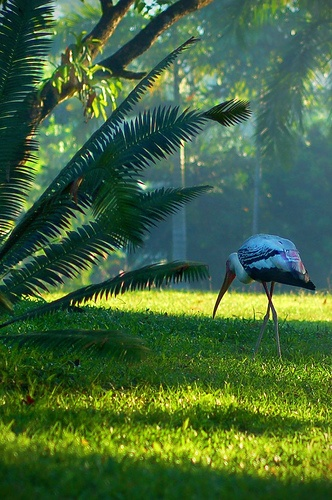

In [13]:
img

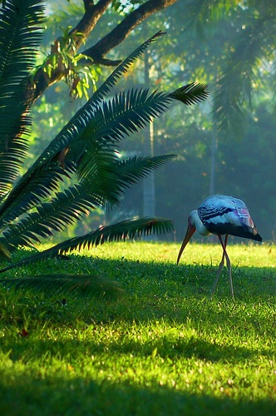

In [14]:
img1

In [15]:
new_image = Image.new('RGB', (w, h), (128, 128, 128))

In [16]:
new_image.paste(img1, (dw_x, dh_y))

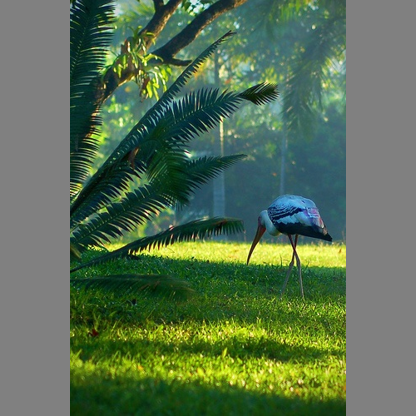

In [17]:
new_image

In [18]:
image_data = np.array(new_image) / 255.

In [19]:
train_csv = pd.read_csv(DATA_DIR + MODE + ".csv", header = None)
train_csv.columns = ['Image', 'label']

In [20]:
len(train_csv)

16551

In [21]:
img_path = os.path.join(IMAGE_DIR, train_csv['Image'][1])
img_path

'D:/01_PythonAIML/00_Datasets/PASCAL_VOC/images/000007.jpg'

In [22]:
image = np.array(Image.open(img_path))

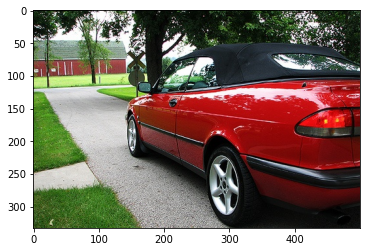

In [23]:
plt.imshow(image)

In [24]:
lbl_path = os.path.join(LABEL_DIR, train_csv['label'][1])
lbl_path

'D:/01_PythonAIML/00_Datasets/PASCAL_VOC/labels/000007.txt'

In [25]:
bboxes = np.roll(np.loadtxt(fname=lbl_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
bboxes

[[0.639, 0.5675675675675675, 0.718, 0.8408408408408409, 6.0]]

In [26]:
img_bboxes_pairs = []
img_bboxes_pairs.append([img_path, bboxes])
img_bboxes_pairs

[['D:/01_PythonAIML/00_Datasets/PASCAL_VOC/images/000007.jpg',
  [[0.639, 0.5675675675675675, 0.718, 0.8408408408408409, 6.0]]]]

In [27]:
def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
    '''Preprocess true boxes to training input format
    Parameters
    ----------
    true_boxes: array, shape=(m, T, 5)
        Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
    input_shape: array-like, hw, multiples of 32
    anchors: array, shape=(N, 2), wh
    num_classes: integer
    Returns
    -------
    y_true: list of array, shape like yolo_outputs, xywh are reletive value
    '''
    assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
    num_layers = len(anchors)//3 # default setting
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

    true_boxes = np.array(true_boxes, dtype='float32')
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
    true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
    true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

    m = true_boxes.shape[0]
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    # Expand dim to apply broadcasting.
    anchors = np.expand_dims(anchors, 0)
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0

    for b in range(m):
        # Discard zero rows.
        wh = boxes_wh[b, valid_mask[b]]
        if len(wh)==0: continue
        # Expand dim to apply broadcasting.
        wh = np.expand_dims(wh, -2)
        box_maxes = wh / 2.
        box_mins = -box_maxes

        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        # Find best anchor for each true box
        best_anchor = np.argmax(iou, axis=-1)

        for t, n in enumerate(best_anchor):
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1

    return y_true

In [28]:
print(2)

2


In [29]:
anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
anchor_idx = 8

In [30]:
scale_idx, anchor_on_scale = [(x, anchor_mask[x].index(anchor_idx)) for x in range(len(anchor_mask)) if anchor_idx in anchor_mask[x]][0]

In [31]:
scale_idx

0

In [32]:
anchor_on_scale

2

### datagenerator

In [33]:
all_indexes = np.arange(48)
all_indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [34]:
self_batch_size = 16
self_batch_size

16

In [35]:
index = 2

In [36]:
batch_indexes = all_indexes[index * self_batch_size: (index + 1) * self_batch_size]
batch_indexes

array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [37]:
list(batch_indexes)

[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

In [38]:
np.random.shuffle(all_indexes)
all_indexes

array([31, 34, 18, 30, 15,  7, 12, 41, 14, 24, 20, 35, 29, 16,  6, 33,  1,
       26, 38, 28, 21,  0, 10, 19, 27,  5, 23,  3, 22, 40, 37, 46, 25, 45,
       36, 42,  9, 32,  8, 39, 13,  4, 43, 11, 17,  2, 44, 47])

### class

In [62]:
class A:
    def __init__(self):
        self.z = 5
    def add_f(self, a, b):
        return a + b + self.z
    def ret_self(self):
        return self.z

In [63]:
class B:
    def __init__(self):
        self.x = A().ret_self()
    def sum_f(self, a, b, c):
        return A().add_f(a, b) + c + self.x

In [64]:
objB = B()
objB.sum_f(1, 2, 3)

11